In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
import time
import matplotlib.pylab as plt
%matplotlib inline
from drive_cadence import Cadence_enhance_basis_function

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
survey_length = 30.#365.25*2.01 # 365.25*10  # days
nside = fs.set_default_nside(nside=32)
years = np.round(survey_length/365.25)
t0 = time.time()

In [3]:
target_map = fs.standard_goals(nside=nside)
norm_factor = fs.calc_norm_factor(target_map)


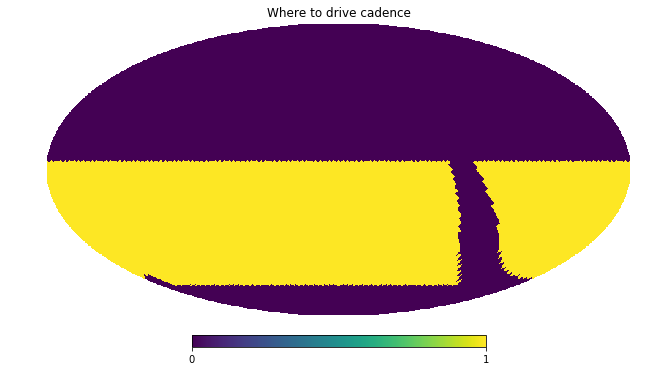

In [4]:
# Set up a map of where to drive the cadence
cadence_area = target_map['r'] * 0
cadence_area[np.where(target_map['r'] == 1)] = 1.
hp.mollview(cadence_area, title='Where to drive cadence')

In [5]:
# Set up observations to be taken in blocks
surveys = []
filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None, 'g', 'r', 'i', None, None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))
    if filtername2 is not None:
        bfs.append(fs.Target_map_basis_function(filtername=filtername2,
                                                target_map=target_map[filtername2],
                                                out_of_bounds_val=hp.UNSEEN, nside=nside,
                                                norm_factor=norm_factor))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=90.))
    # Here's the new one
    bfs.append(Cadence_enhance_basis_function(nside=nside, apply_area=cadence_area))
    weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0., 1.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works properly.
        weights = np.array([6.0, 0.6, 3., 3., 0., 1.])
    
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    surveys.append(fs.Blob_survey(bfs, weights, filtername=filtername,
                                       filter2=filtername2,
                                       survey_note=survey_name))
    pair_surveys.append(surveys[-1])


In [6]:
filters = ['i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=90.))
    weights = np.array([3.0, 0.3, 1., 3., 3., 0])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))
    greedy_surveys.append(surveys[-1])

In [7]:
survey_list_o_lists = [pair_surveys, greedy_surveys]

In [8]:
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
n_visit_limit = None
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='cad_test_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)
t1 = time.time()
delta_t = t1-t0
print('ran in %.1f min = %.1f hours' % (delta_t/60., delta_t/3600.))


/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 28.6%

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:313: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:229: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


progress = 100.0%Skipped 0 observations
Completed 15746 observations
ran in 25.9 min = 0.4 hours


In [9]:
np.mean(observations['slewtime'])

9.62205442150516

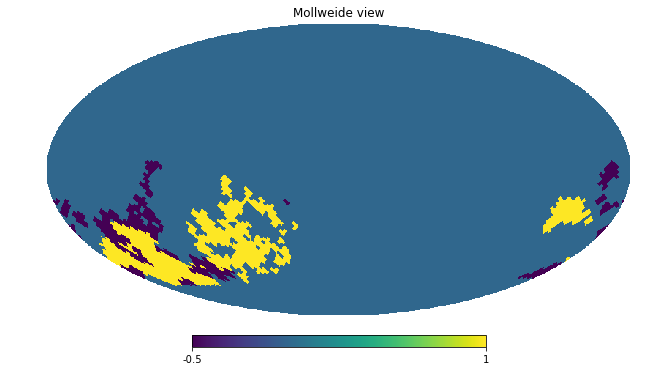

In [10]:
hp.mollview(surveys[0].basis_functions[-1]())

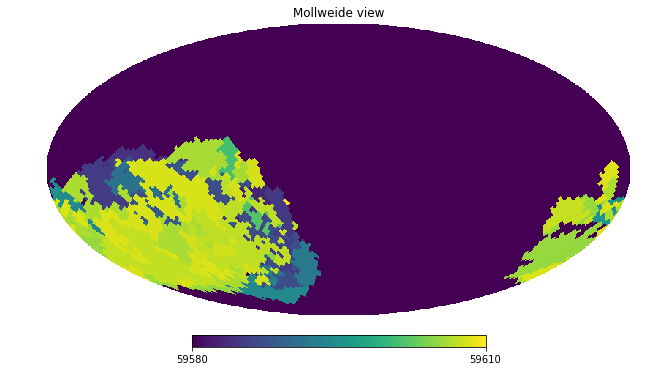

In [11]:
hp.mollview(surveys[0].basis_functions[-1].survey_features['last_observed'].feature, min=59580)

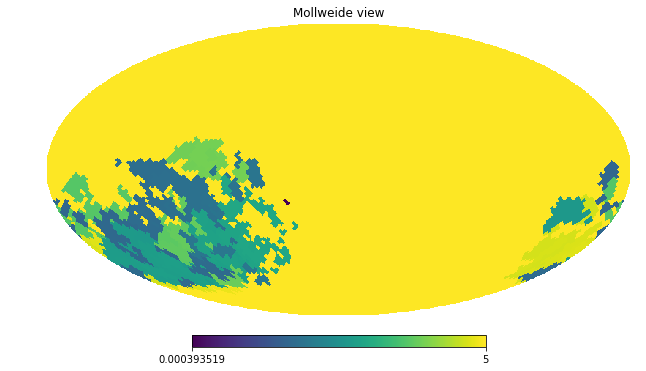

In [12]:
hp.mollview(surveys[0].basis_functions[-1].condition_features['Current_mjd'].feature - 
            surveys[0].basis_functions[-1].survey_features['last_observed'].feature, max=5)